# Bike Sharing Demand - 16/03/2022

### 1 - Kaggle link competition - https://www.kaggle.com/c/bike-sharing-demand/overview

In [265]:
#Importing all libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import statsmodels.formula.api as smf
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import xgboost as xg
import warnings
#Hiding all warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [146]:
# Importing train and test dataset for EDA
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [147]:
#Creating functions
def plotting_graph(dataset, x=None, y=None, hue=None, title=None, xlabel= None, ylabel = None):
    ax = sns.set_theme()
    ax = sns.pointplot(data = dataset, x = x, y = y, hue = hue, ci = 0)
    ax.figure.set_size_inches(15,8)
    ax.set_title(title, loc = 'left', fontsize = 17)
    ax.set_xlabel(xlabel, loc = 'center', fontsize = 14 )
    ax.set_ylabel(ylabel, loc = 'center', fontsize = 14)
    return ax


def metrics_report(y, y_pred, dataset_name='valid'):
    mean_y = np.mean(y)
    mean_pred = np.mean(y_pred)

    rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)

    report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
    })

    report[dataset_name] = report[dataset_name].round(2)
    return report

In [148]:
train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [149]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [150]:
#Seeing the shape of the dataset
train.shape

(10886, 12)

In [151]:
#Converting the datetime variable to datetime
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

In [152]:
#Creating variables for days of the week, month, hour and day 
train['dayofweek'] = train.datetime.dt.day_of_week
train['month'] = train.datetime.dt.month
train['hour'] = train.datetime.dt.hour
train['day'] = train.datetime.dt.day
test['dayofweek'] = test.datetime.dt.day_of_week
test['month'] = test.datetime.dt.month
test['hour'] = test.datetime.dt.hour
test['day'] = test.datetime.dt.day

In [153]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dayofweek,month,hour,day
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,5,1,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,5,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,5,1,2,1
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,5,1,3,1
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,5,1,4,1


In [154]:
# Creating dictionaries for the categorical variables
season_name = {1 : 'spring', 2 : 'summer', 3 : 'fall', 4 : 'winter'}
weather_name = {1: 'Clear', 2: 'Mist', 3: 'Light Snow', 4: 'Heavy Rain'}
day_week_name = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
month_name = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June',
              7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

In [155]:
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dayofweek              int64
month                  int64
hour                   int64
day                    int64
dtype: object

In [156]:
#Analysing the null variables
print(f'A quantidade de valores nulos é {train.isnull().sum().sum()}.')

A quantidade de valores nulos é 0.


In [157]:
#Correlation Matrix
train.corr().round(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dayofweek,month,hour,day
season,1.00,0.03,-0.01,0.01,0.26,0.26,0.19,-0.15,0.10,0.16,0.16,-0.01,0.97,-0.01,0.00
holiday,0.03,1.00,-0.25,-0.01,0.00,-0.01,0.00,0.01,0.04,-0.02,-0.01,-0.19,0.00,-0.00,-0.02
workingday,-0.01,-0.25,1.00,0.03,0.03,0.02,-0.01,0.01,-0.32,0.12,0.01,-0.70,-0.00,0.00,0.01
weather,0.01,-0.01,0.03,1.00,-0.06,-0.06,0.41,0.01,-0.14,-0.11,-0.13,-0.05,0.01,-0.02,-0.01
temp,0.26,0.00,0.03,-0.06,1.00,0.98,-0.06,-0.02,0.47,0.32,0.39,-0.04,0.26,0.15,0.02
atemp,0.26,-0.01,0.02,-0.06,0.98,1.00,-0.04,-0.06,0.46,0.31,0.39,-0.04,0.26,0.14,0.01
humidity,0.19,0.00,-0.01,0.41,-0.06,-0.04,1.00,-0.32,-0.35,-0.27,-0.32,-0.03,0.20,-0.28,-0.01
windspeed,-0.15,0.01,0.01,0.01,-0.02,-0.06,-0.32,1.00,0.09,0.09,0.10,-0.02,-0.15,0.15,0.04
casual,0.10,0.04,-0.32,-0.14,0.47,0.46,-0.35,0.09,1.00,0.50,0.69,0.25,0.09,0.30,0.01
registered,0.16,-0.02,0.12,-0.11,0.32,0.31,-0.27,0.09,0.50,1.00,0.97,-0.08,0.17,0.38,0.02


In [158]:
#Reoorganizing the columns
#Other important information is related to Registered and casual, since count is the sum of them we area going to delete it
train = train[['datetime', 'holiday', 'workingday', 'dayofweek', 'month', 'hour', 'day',
         'weather', 'temp','season','atemp', 'humidity', 'windspeed', 'count']]

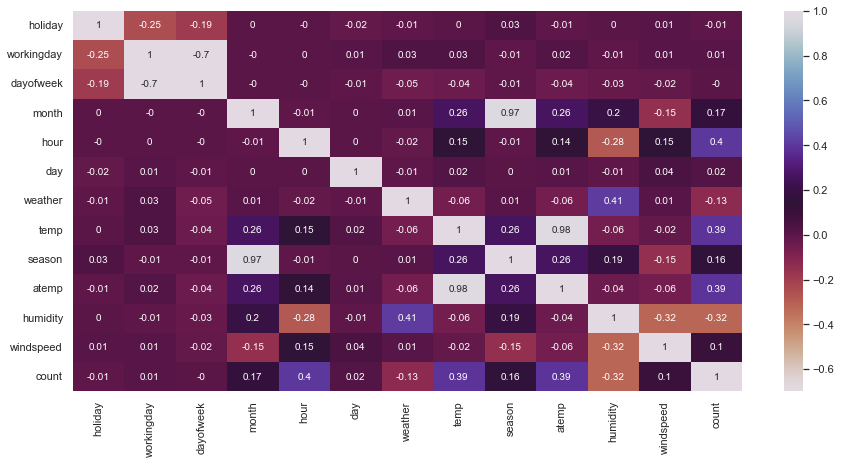

In [159]:
ax = sns.heatmap(train.corr().round(2), annot=True, cmap= 'twilight_r')
ax.figure.set_size_inches(15,7)

<AxesSubplot:title={'left':'Number of rentals by time of the day'}, xlabel='Time of the day (hrs)', ylabel='Number of rentals'>

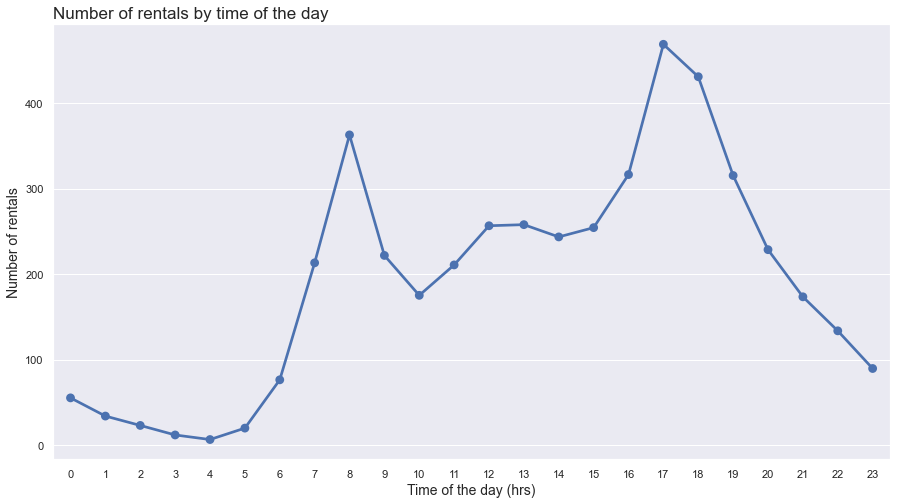

In [160]:
#Plotting the line graph for the rental variable
plotting_graph(train, 'hour','count',None,'Number of rentals by time of the day', 'Time of the day (hrs)', 'Number of rentals' )

In the plotting above we see peaks of bicycle rental occuring in the morning from 7 am to 9 am and in the afternoon from 4 pm to 7 pm. It was what we expected, since these periods are rush hour that population is commuting to work and from work to their home.

### Let's analyse the rentals by crossing other independent variables

<AxesSubplot:title={'left':'Number of rentals by time of the day and weather conditions'}, xlabel='Time of the day (hrs)', ylabel='Number of rentals'>

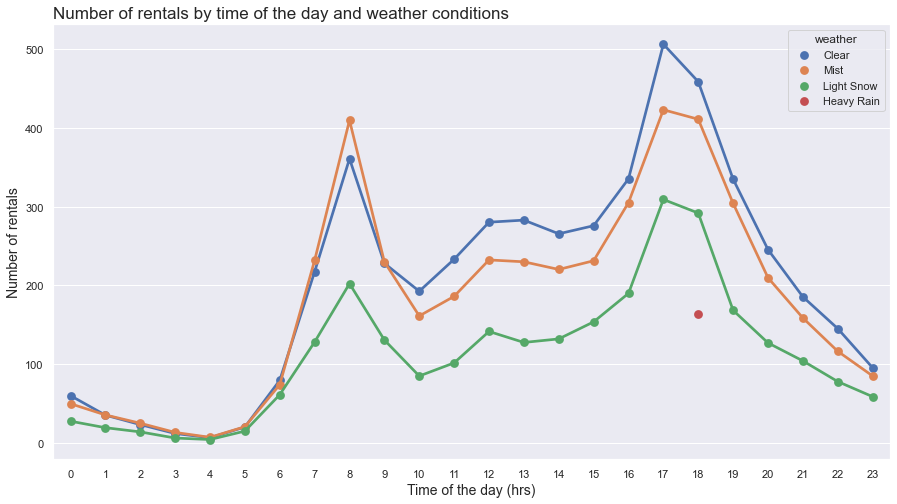

In [161]:
# Crossing rentals versus time of the day and weather
plotting_graph(train, 'hour','count',train['weather'].map(weather_name),
               'Number of rentals by time of the day and weather conditions', 'Time of the day (hrs)', 'Number of rentals' )

We see above that the peak hour is the same where clear and mist weather have more rentals than others and we can see on heavy rains does not have reantals.

<AxesSubplot:title={'left':'Number of rentals by time of the day and season'}, xlabel='Time of the day (hrs)', ylabel='Number of rentals'>

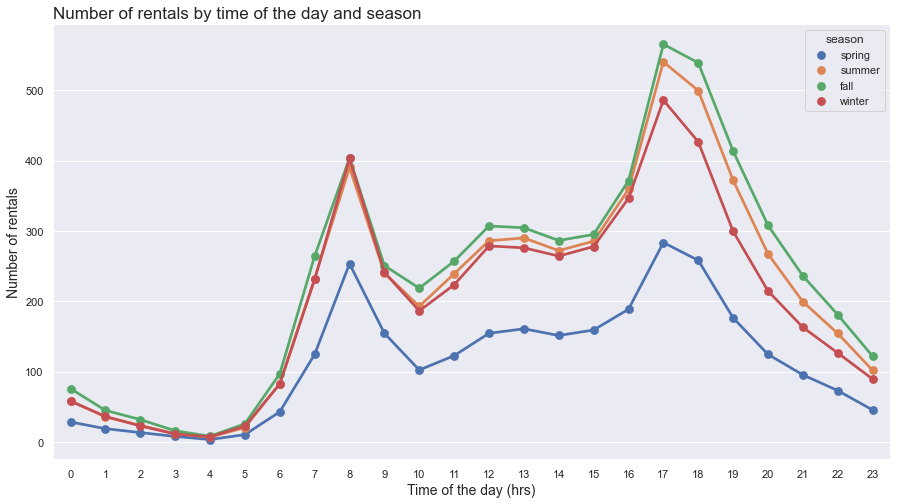

In [162]:
# Crossing rentals versus time of the day and Seasons
plotting_graph(train, 'hour','count',train['season'].map(season_name),
               'Number of rentals by time of the day and season', 'Time of the day (hrs)', 'Number of rentals' )

We see the peaks for rush hour and more rentals for summer ans fall seasons.

<AxesSubplot:title={'left':'Number of rentals by time of the day and weather conditions'}, xlabel='Time of the day (hrs)', ylabel='Number of rentals'>

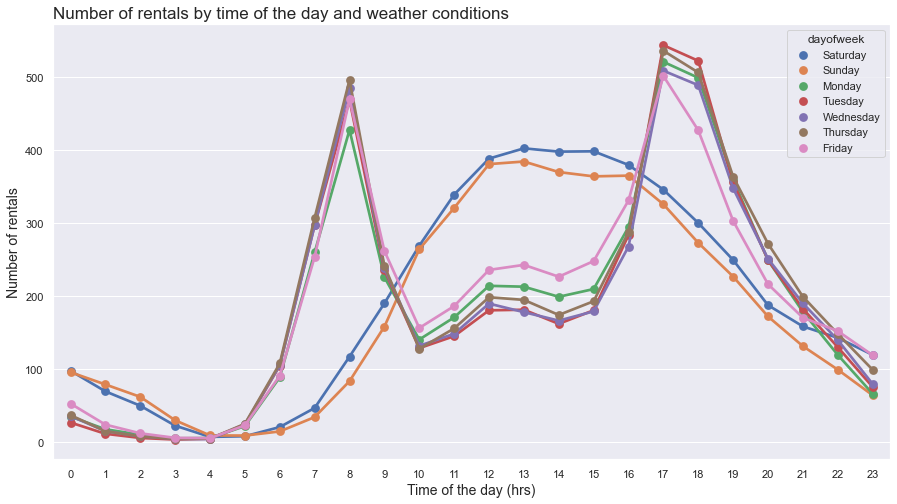

In [163]:
# Crossing rentals versus time of the day and days of the week
plotting_graph(train, 'hour','count',train['dayofweek'].map(day_week_name),
               'Number of rentals by time of the day and weather conditions', 'Time of the day (hrs)', 'Number of rentals' )

The peak for rush hours occurs just on weekdays being that on the weekdays the distribution of rentals are quite equivalent. For the weekends we see peaks between 13hrs to 16hrs, probably because is the most suitable hour to ride a bicycle considering on sundays more rentals than saturday.

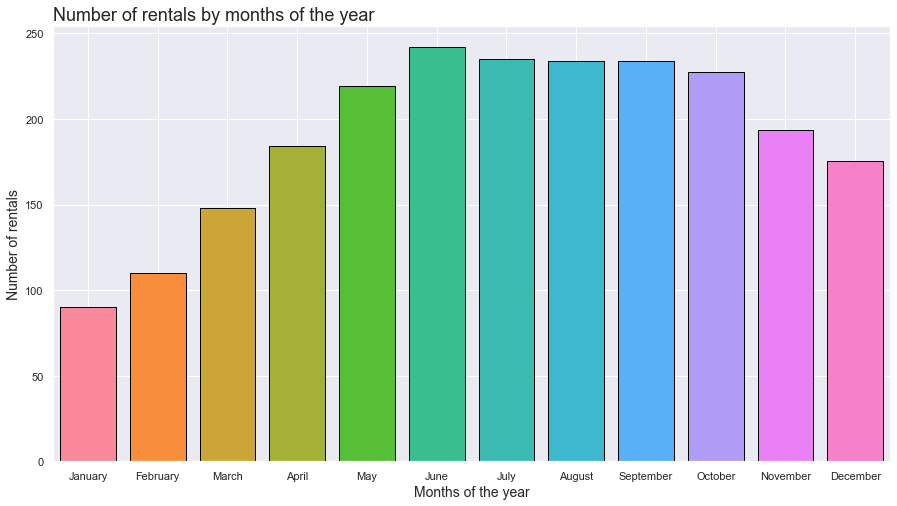

In [164]:
#Bar plotting graph is most suitable to understand the rentals by months
ax = sns.barplot(data = train, x = train['month'].map(month_name), y = 'count', ci = 0, linewidth=1,
                 saturation=1, edgecolor=(0,0,0))
ax.figure.set_size_inches(15,8)
ax.grid(True)
ax.set_title('Number of rentals by months of the year', loc = 'left', fontsize = 18)
ax.set_xlabel('Months of the year', loc = 'center', fontsize = 14)
ax.set_ylabel('Number of rentals', loc = 'center', fontsize = 14)
ax = ax

For the analyse above we see from January to June the number of rentals are increasing gradually, stabilizing from June to September where starts to decrease. This behavoir probably happens because the Summer starts in June and finishes in August. September likely keeps the mild temperature so still have equivalent number of rentals from the backwards months and from October onwards the rentals starts decreasing.

In [165]:
#Describing the variables
train.describe(percentiles = [0.25,0.50,0.75,0.95,0.99])

,holiday,workingday,dayofweek,month,hour,day,weather,temp,season,atemp,humidity,windspeed,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,3.013963,6.521495,11.541613,9.992559,1.418427,20.23086,2.506614,23.655084,61.886460,12.799395,191.574132
std,0.166599,0.466159,2.004585,3.444373,6.915838,5.476608,0.633839,7.79159,1.116174,8.474601,19.245033,8.164537,181.144454
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.82000,1.000000,0.760000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,1.000000,4.000000,6.000000,5.000000,1.000000,13.94000,2.000000,16.665000,47.000000,7.001500,42.000000
50%,0.000000,1.000000,3.000000,7.000000,12.000000,10.000000,1.000000,20.50000,3.000000,24.240000,62.000000,12.998000,145.000000
75%,0.000000,1.000000,5.000000,10.000000,18.000000,15.000000,2.000000,26.24000,4.000000,31.060000,77.000000,16.997900,284.000000
95%,0.000000,1.000000,6.000000,12.000000,22.000000,19.000000,3.000000,32.80000,4.000000,36.365000,93.000000,27.999300,563.750000
99%,1.000000,1.000000,6.000000,12.000000,23.000000,19.000000,3.000000,36.08000,4.000000,40.150000,100.000000,35.000800,774.150000
max,1.000000,1.000000,6.000000,12.000000,23.000000,19.000000,4.000000,41.00000,4.000000,45.455000,100.000000,56.996900,977.000000


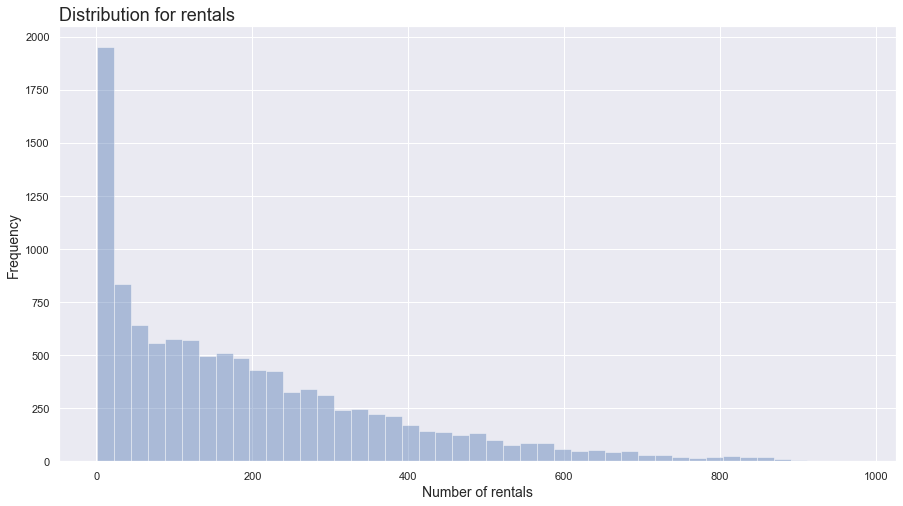

In [166]:
#Let's analyse an histogram for the count variable, using the frequency instead of density
ax = sns.distplot(x= train['count'], kde = False, norm_hist=False)
ax.figure.set_size_inches(15,8)
ax.grid(True)
ax.set_title('Distribution for rentals', loc = 'left', fontsize = 18)
ax.set_xlabel('Number of rentals', loc = 'center', fontsize = 14 )
ax.set_ylabel('Frequency', loc = 'center', fontsize = 14)
ax = ax

It seens the distribution is right-skewed, let's apply the log to normalize the distribution

In [167]:
train['log_count'] = np.log(train['count'])

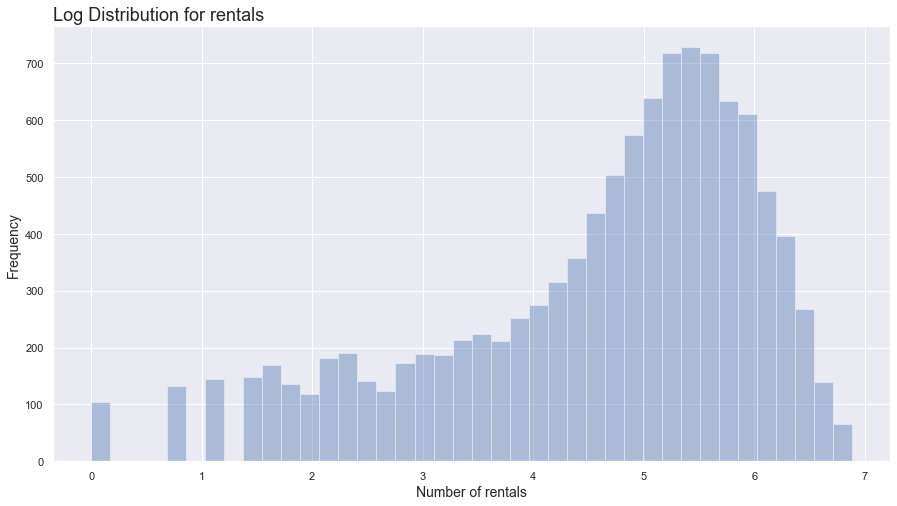

In [168]:
#Let's analyse an histogram for the new log variable
ax = sns.distplot(train['log_count'], kde = False, norm_hist=False)
ax.figure.set_size_inches(15,8)
ax.grid(True)
ax.set_title('Log Distribution for rentals', loc = 'left', fontsize = 18)
ax.set_xlabel('Number of rentals', loc = 'center', fontsize = 14 )
ax.set_ylabel('Frequency', loc = 'center', fontsize = 14)
ax = ax

The log does not affect the distribution and still not a normal. <br>
Running the analysis if the sample is large enough, although many hypothesis tests are formally based on the normality assumption, you can still get good results with non-normal data if your sample is large enough. The amount of data you need depends on how non-normal your data is, but a sample size of 20 is often adequate. The relationship between robustness for normality and sample size is based on the central limit theorem. This theorem proves that the mean data distribution of any distribution approaches the normal distribution as the sample size increases. Therefore, if you are interested in making an inference about a population mean, the normality assumption is not critical as long as your sample is large enough.

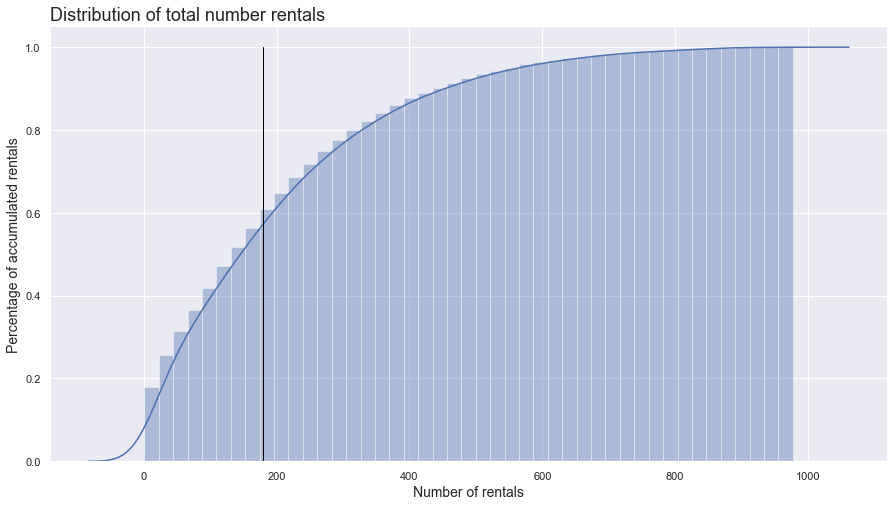

In [169]:
#Let's analyse an histogram for the count variable, using cumulative function
ax = sns.distplot(x= train['count'], hist_kws={'cumulative':True}, kde_kws={'cumulative':True})
ax.figure.set_size_inches(15,8)
ax.grid(True)
ax.set_title('Distribution of total number rentals', loc = 'left', fontsize = 18)
ax.set_xlabel('Number of rentals', loc = 'center', fontsize = 14 )
ax.set_ylabel('Percentage of accumulated rentals', loc = 'center', fontsize = 14)
ax = sns.lineplot(x=[180,180], y = [0,1], color='black', estimator = None, linewidth = 1)
ax = ax

Analysing the accumulated histogram drawing a line we see  above 180 bicycle rented are concentrated above the 56.5% of the rentals and right-skewed.

In [170]:
#Right skewed where mode < median < mean. Let's see this information. 
mode = train['count'].mode()
mean = train['count'].mean()
median = train['count'].quantile(0.5)
print(mode[0] < median < mean)
print('Bimodal Distribution')

True
Bimodal Distribution


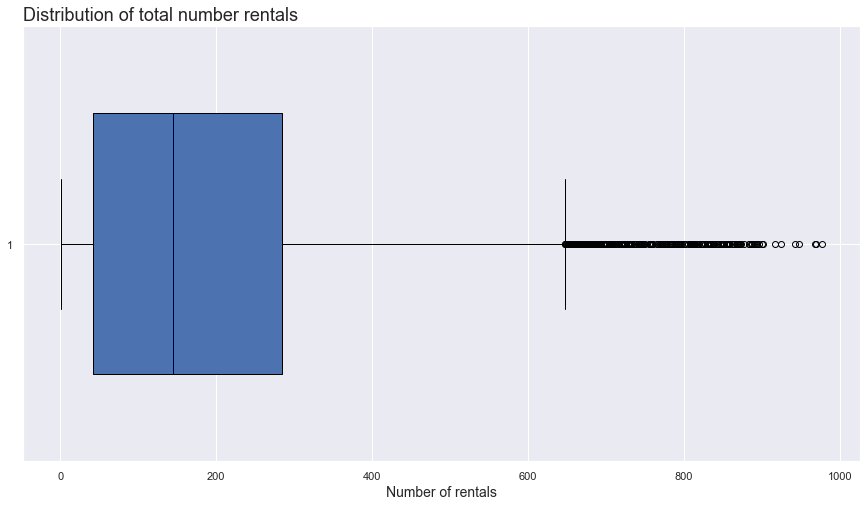

In [171]:
# Let's plot the rentals on a boxplot
plt.figure(figsize=(15,8))
ax = plt.boxplot(train['count'], vert= False, patch_artist= True, widths=0.6, medianprops=dict(color='black'))
plt.title('Distribution of total number rentals', loc = 'left', fontsize = 18)
plt.xlabel('Number of rentals', fontsize=14)
ax = ax

### Bivariate analysis for dependent versus independent variables.

### Statistical analysis:
H0: The number of rentals do not have influence by  season or Summer = Winter = Spring = Fall

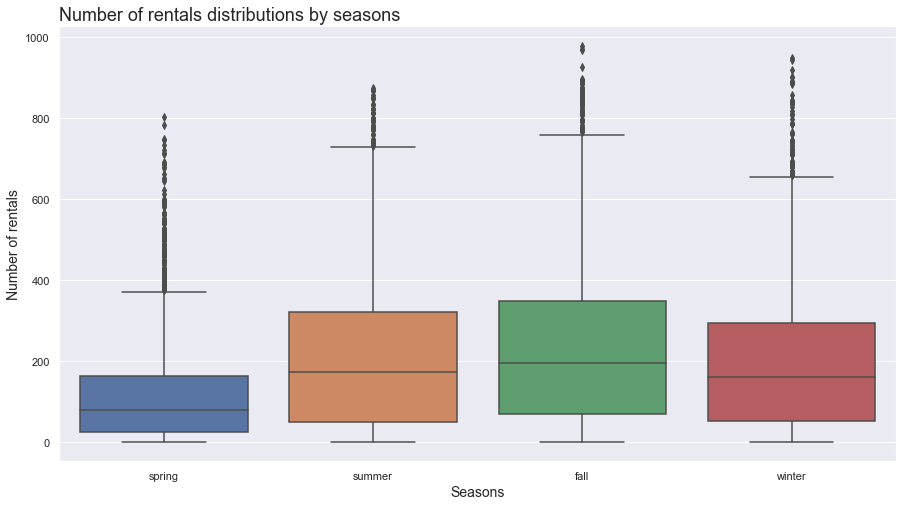

In [172]:
# Boxplot number of rentals bye seasons
plt.figure(figsize=(15,8))
ax = sns.boxplot(data = train, x = train['season'].map(season_name), y = 'count')
plt.title('Number of rentals distributions by seasons', loc = 'left', fontsize = 18)
plt.xlabel('Seasons', fontsize = 14)
plt.ylabel('Number of rentals', fontsize = 14)
ax = ax

In [173]:
#We will use the F-Oneway ANOVA since we have more two variables to test

df_aux = train[['count','season']]
stats, p_value = f_oneway( df_aux[df_aux['season'] == 1]['count'],
                           df_aux[df_aux['season'] == 2]['count'],
                           df_aux[df_aux['season'] == 3]['count'],
                           df_aux[df_aux['season'] == 4]['count'],
                          )                          
print(f'Stats: {stats.round(2)} and P-Value:{p_value.round(2)}')

Stats: 236.95 and P-Value:0.0


In [174]:
tukey = pairwise_tukeyhsd(df_aux['count'], df_aux['season'], alpha = 0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2  98.9081   -0.0  86.6544 111.1618   True
     1      3 118.0739   -0.0 105.8202 130.3276   True
     1      4   82.645   -0.0  70.3924  94.8976   True
     2      3  19.1658 0.0003   6.9653  31.3662   True
     2      4 -16.2631 0.0034 -28.4624  -4.0637   True
     3      4 -35.4288   -0.0 -47.6282 -23.2295   True
------------------------------------------------------


Statistically we can say the seasons affect the rentals so we reject the null hypothesis.

H0: The number of rentals do not have influence by weather
Since we have just 1 observation for heavy rain we decided to delete the heavy rain.

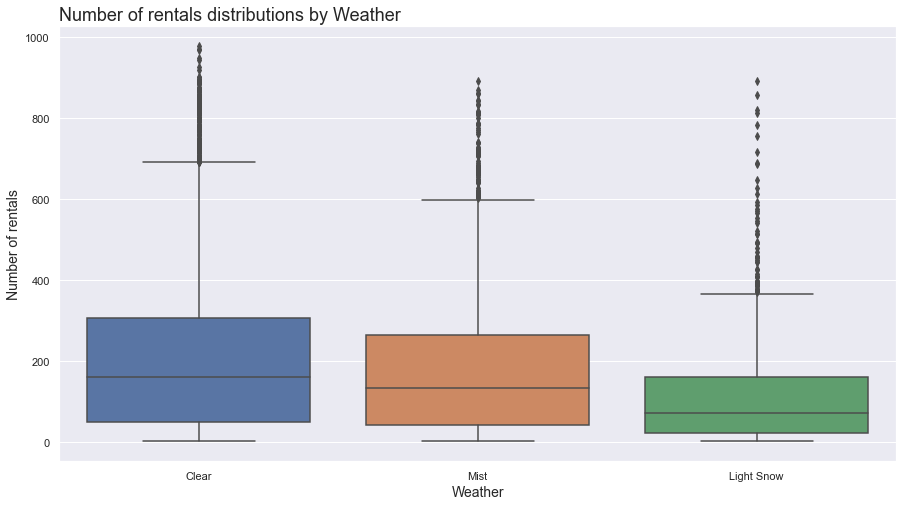

In [175]:
# Boxplot number of rentals bye seasons
plt.figure(figsize=(15,8))
ax = sns.boxplot(data = train[train.weather != 4], x = train['weather'].map({1: 'Clear', 2: 'Mist', 3: 'Light Snow'}), y = 'count')
plt.title('Number of rentals distributions by Weather', loc = 'left', fontsize = 18)
plt.xlabel('Weather', fontsize = 14)
plt.ylabel('Number of rentals', fontsize = 14)
ax = ax

In [176]:
#We will use the F-Oneway ANOVA since we have more two variables to test
df_aux = train[train.weather != 4][['count','weather']]
stats, p_value = f_oneway( df_aux[df_aux['weather'] == 1]['count'],
                           df_aux[df_aux['weather'] == 2]['count'],
                           df_aux[df_aux['weather'] == 3]['count'],
                          )                          
print(f'Stats: {stats.round(2)} and P-Value:{p_value.round(2)}')

Stats: 98.28 and P-Value:0.0


In [177]:
tukey = pairwise_tukeyhsd(df_aux['count'], df_aux['weather'], alpha = 0.05)

print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2 -26.2813   0.0  -35.6159 -16.9466   True
     1      3 -86.3905  -0.0 -101.5841 -71.1968   True
     2      3 -60.1092  -0.0   -76.502 -43.7165   True
------------------------------------------------------


Statistically we can say the weather conditions affect the rentals so we reject the null hypothesis.

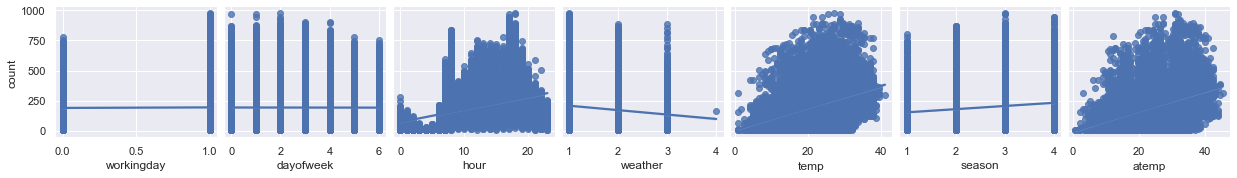

In [178]:
#We still could see how is the how the independent variables influence in the dependent variable, plotting the scatterplots
#Other important information is related to Registered and casual, since count is the sum of them we area going to delete it
sns.pairplot(data=train, y_vars= 'count', x_vars= ['workingday', 'dayofweek', 'hour',
         'weather', 'temp','season','atemp'], kind='reg' )

In [185]:
X_train

,holiday,workingday,dayofweek,month,hour,day,weather,temp,season,atemp,humidity,windspeed
1101,0,1,3,3,12,10,3,17.22,1,21.210,0,15.0013
4194,0,1,3,10,19,6,1,21.32,4,25.000,59,7.0015
10389,0,0,6,11,7,18,1,11.48,4,13.635,81,12.9980
6969,0,0,6,4,17,8,1,25.42,2,30.305,22,19.9995
313,0,1,4,1,13,14,1,9.02,1,9.850,37,26.0027
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0,0,5,1,2,14,1,6.56,1,8.335,47,11.0014
5191,0,0,5,12,9,10,1,11.48,4,12.880,61,19.0012
5390,0,0,6,12,16,18,1,11.48,4,13.635,48,16.9979
860,0,0,5,2,7,19,1,15.58,1,19.695,17,35.0008


In [306]:
# Split train & test
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['count', 'log_count','datetime'], axis =1)
                                                    , train['log_count'],test_size=0.33)

In [307]:
#Fitting the model
regressor = RandomForestRegressor(n_estimators=150)
regressor.fit(X_train,y_train)
baseline_report = metrics_report(y_test, regressor.predict(X_test), 'Test')
baseline_report

,metric,Test
0,RMSE,4.000000e-01
1,MAE,3.000000e-01
2,R^2,9.300000e-01
3,MAPE,3.941296e+13
4,Avg. target,4.560000e+00
5,Avg. Prediction,4.560000e+00


In [308]:
#Looping to find the best hiperparameter n_estimator
dic_n_estimator = {}
for n in [10, 30, 50, 70, 100, 150, 200]:
    modelo = RandomForestRegressor(n_estimators=n, random_state=42)
    modelo.fit(X_train, y_train)
    y_test_pred = modelo.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
    dic_n_estimator[n] = rmse
for i in dic_n_estimator:
    if dic_n_estimator[i]==min(dic_n_estimator.values()):
        best_n_estimator = i

In [309]:
#Looping to find the best hiperparameter max_features
dic_max_features={}
for max_features in [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8]:
    modelo = RandomForestRegressor(n_estimators=best_n_estimator, max_features=max_features, random_state=42)
    modelo.fit(X_train, y_train)
    y_test_pred = modelo.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
    dic_max_features[max_features] = rmse
for i in dic_max_features:
    if dic_max_features[i]==min(dic_max_features.values()):
        best_max_feature = i

In [310]:
#Looping to find the best hiperparameter min_samples
dic_min_samples_leaf = {}
for min_samples_leaf in list(range(1,8)):
    modelo = RandomForestRegressor(n_estimators=best_n_estimator, max_features=best_max_feature, min_samples_leaf= min_samples_leaf, random_state=42)
    modelo.fit(X_train, y_train)
    y_test_pred = modelo.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
    dic_min_samples_leaf[min_samples_leaf] = rmse
for i in dic_min_samples_leaf:
    if dic_min_samples_leaf[i]==min(dic_min_samples_leaf.values()):
        best_min_sample_leaf = i

In [311]:
#Considering the best parameters let's run again the regression
regressor = RandomForestRegressor(n_estimators=best_n_estimator, max_features=best_max_feature, 
                                  min_samples_leaf= best_min_sample_leaf, random_state=42)
regressor.fit(X_train,y_train)
baseline_report = metrics_report(y_test, regressor.predict(X_test), 'Test')
baseline_report

,metric,Test
0,RMSE,3.900000e-01
1,MAE,2.900000e-01
2,R^2,9.300000e-01
3,MAPE,4.048856e+13
4,Avg. target,4.560000e+00
5,Avg. Prediction,4.560000e+00


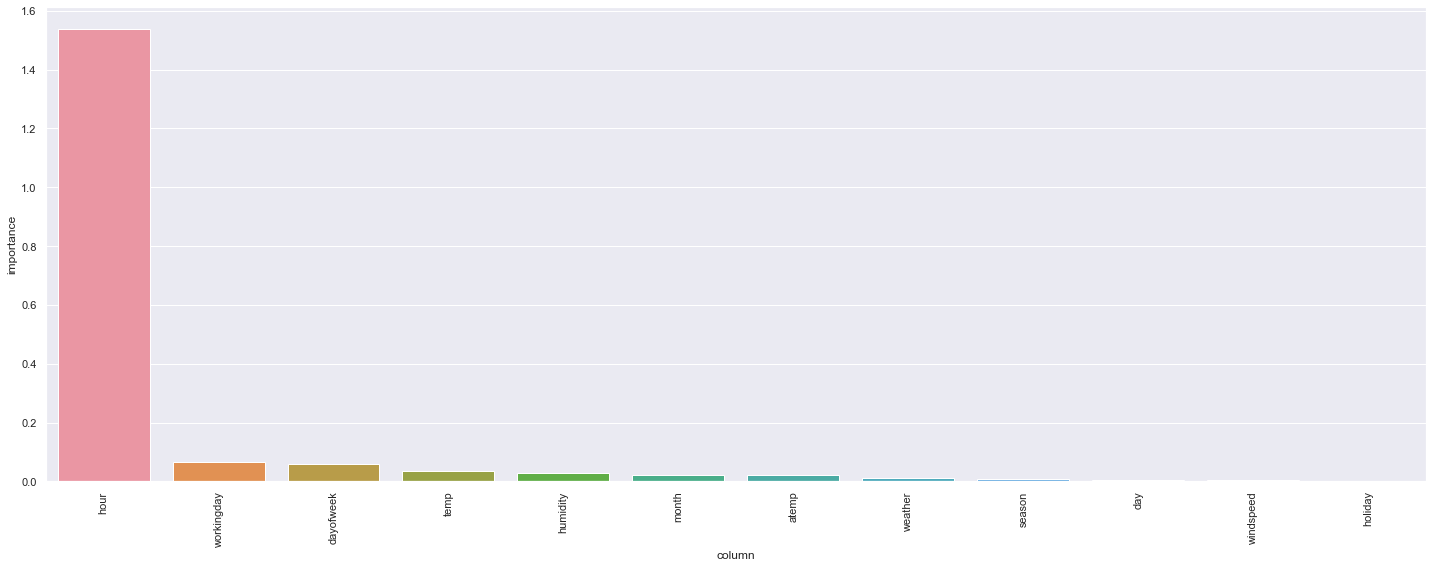

In [312]:
# LEt's run the feature importance and we are coing to plot all variables by relevance
permutation_result = permutation_importance(regressor, X_test, y_test, n_repeats=5, random_state=42)

importances = pd.DataFrame({'column' : X_test.columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()

In [313]:
best_features = list(importances.nlargest(8, 'importance').column)
print(best_features)

['hour', 'workingday', 'dayofweek', 'temp', 'humidity', 'month', 'atemp', 'weather']


In [314]:
#Re-training the model with only the most relevants features
model = RandomForestRegressor(n_estimators=best_n_estimator, max_features=best_max_feature, 
                                  min_samples_leaf= best_min_sample_leaf, random_state=42)
model.fit(X_train[best_features], y_train)

# GEnerating the predictions for X_train, X_test
y_train_pred = model.predict(X_train[best_features])
y_test_pred = model.predict(X_test[best_features])

# GEnerating the metrics for X_train, X_test 
train_report = metrics_report(y_train, y_train_pred, 'train')
test_report = metrics_report(y_test, y_test_pred, 'test')

final_report = pd.concat([train_report,  test_report[['test']]], axis=1)

print(f'Baseline report (total features: {len(X_train.columns)})')
print(baseline_report)
print('')
print(f'Final report (total features: {len(best_features)})')
print(final_report)

Baseline report (total features: 12)
            metric          Test
0             RMSE  3.900000e-01
1              MAE  2.900000e-01
2              R^2  9.300000e-01
3             MAPE  4.048856e+13
4      Avg. target  4.560000e+00
5  Avg. Prediction  4.560000e+00

Final report (total features: 8)
            metric         train          test
0             RMSE  1.500000e-01  4.000000e-01
1              MAE  1.100000e-01  3.000000e-01
2              R^2  9.900000e-01  9.300000e-01
3             MAPE  1.965595e+13  4.147470e+13
4      Avg. target  4.550000e+00  4.560000e+00
5  Avg. Prediction  4.550000e+00  4.560000e+00


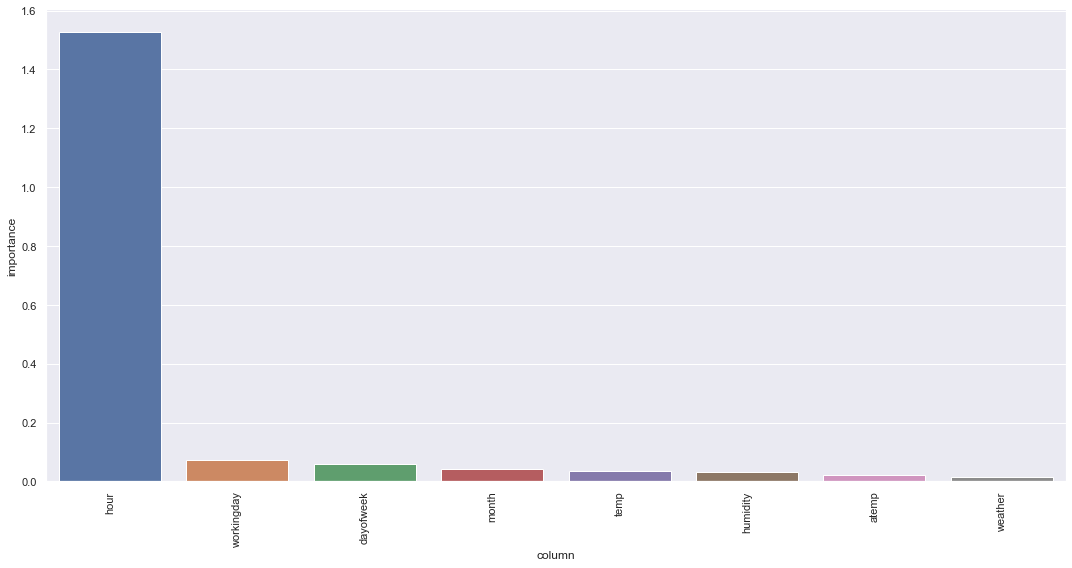

In [315]:
# Plotting the model with the best features
permutation_result = permutation_importance(model, X_test[best_features], y_test, n_repeats=5, random_state=42)

importances = pd.DataFrame({'column' : X_test[best_features].columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(15,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()

<AxesSubplot:xlabel='log_count', ylabel='Density'>

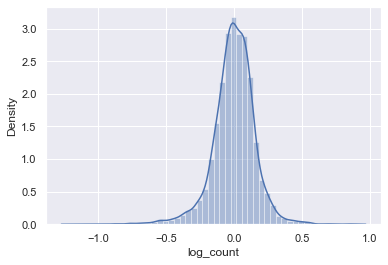

In [316]:
sns.distplot(y_train-y_train_pred)

<AxesSubplot:xlabel='log_count', ylabel='Density'>

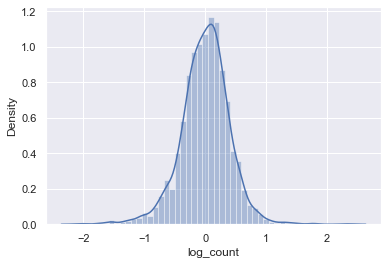

In [317]:
sns.distplot(y_test-y_test_pred)

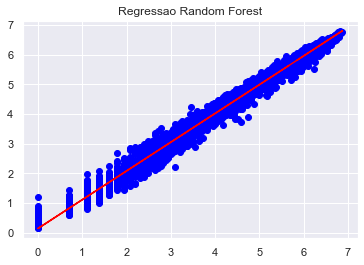

In [318]:
plt.scatter(y_train, model.predict(X_train[best_features]), color = 'blue')
m, b = np.polyfit(y_train, model.predict(X_train[best_features]), 1)
plt.plot(y_train, m*y_train + b,color ='red')
plt.title('Regressao Random Forest')
plt.show()

In [344]:
#Converting the datetime variable to datetime
test['datetime'] = pd.to_datetime(test['datetime'])
#Creating variables for days of the month, hour and day to generate the submission for the test
test['month'] = test.datetime.dt.month
test['hour'] = test.datetime.dt.hour
test['dayofweek'] = test.datetime.dt.dayofweek
y_test_pred = np.exp(model.predict(test[best_features])).astype('int')

In [345]:
output = pd.DataFrame({"datetime": test.datetime,
                       "count": y_test_pred.astype('int')})
output.to_csv('data/submission.csv', index=False)

In [346]:
output

,datetime,count
0,2011-01-20 00:00:00,15
1,2011-01-20 01:00:00,6
2,2011-01-20 02:00:00,4
3,2011-01-20 03:00:00,4
4,2011-01-20 04:00:00,2
...,...,...
6488,2012-12-31 19:00:00,266
6489,2012-12-31 20:00:00,194
6490,2012-12-31 21:00:00,124
6491,2012-12-31 22:00:00,114
